In [208]:
import uuid
from datetime import datetime
from typing import Callable
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import tqdm
import warnings


class DataStoreException(Exception):
    pass

class DataStoreWarning(Exception):
    pass


class DataStore:
    def __init__(self,
                 name=(uuid.uuid4()),
                 cold_start=True,
                 padding=True,
                 differential=300,
                 indicators=list()):
        self._name = name
        self._init_time = datetime.today().strftime('%Y-%m-%d %H:%m:%S')
        self._cold_start = cold_start
        self._indicators = indicators
        self._data = list()
        self._differential = differential
        self._counter = 0
        self._indicator_values = dict()
    
    def add_datum(self,datum):
        # check correct object type
        if not isinstance(datum,dict):
            raise DataStoreException('datum must be a python dictionary type object')
            #print('uhh oohhhhh!!!')
            
        # check it has the correct keys
        if 'timestamp' not in datum:
            raise DataStoreException('timestamp key must be provided in datum')
            
        if len(self._data)==0:
            self._data.append(datum)
            self._data_df = pd.DataFrame(datum,index=[self._counter])
            self._counter+=1
        else:
            # check the time differential between data points
            differential = datum['timestamp'] - self._data[-1]['timestamp']
            if differential!=self._differential:
                #raise DataStoreException(f'differential of {differential} did not match the stated differential.')
                print('uhh oohhhhh!!!')
                
            self._data.append(datum)
            
            data_df = pd.DataFrame(datum,index=[self._counter])
            self._data_df = pd.concat([self._data_df,data_df],axis=0)
            
            self.calc_indicators()
            self._counter+=1
            
    def add_data_item(self,data_item,data_item_name):
        last_index = self._data_df.index[-1]
        self._data_df.loc[last_index,data_item_name] = data_item
            
    def calc_indicators(self):
        for indicator in self._indicators:
            if isinstance(indicator, Callable):
                indicator_value = indicator(self._data_df)
                self._data_df.loc[self._counter,indicator.__name__] = indicator_value
                self._indicator_values[indicator.__name__] = indicator_value

def mean_l4(x):
    return np.mean(x['close'][-4:])

def trend_l4(x):
    print(len(x))
    if len(x)<=3:
        return 0
    else:
        X = x['close'][-4:]
        Y = x['timestamp'][-4:]
        return np.polyfit(X,Y,1)[0]

import math

def logit(x):
    return 1/(1+math.exp(-0.001*x+0.1))

def model_prob(x):
    #print(x['close'].shape)
    return logit(x['close'][-1:])


if __name__=='__main__':
    # Just checking that the code actually works
    model = keras.models.load_model('C:\\Users\\cemly\\Documents\\TimeSeriesForecasting\\StockPrediction\\cnn_model')
    
    def cnn_predict(x):
        if len(x)>21:
            X = x[['volume','close','open','high','low']][-21:].values.reshape(1,21,5)
            #print(X)
            return model.predict(X,verbose=0).item(0)
        else:
            return np.nan

    a = DataStore(cold_start=True,indicators=[mean_l4,model_prob,cnn_predict])
    
    start = 400
    for i in tqdm.tqdm(range(1,600)):
        if i==1:
            a.add_datum({'timestamp':i*300,'close':start,'high':start,'low':start,'open':start,'volume':start})
        else:
            start = start+random.randint(-10,10)
            a.add_datum({'timestamp':i*300,'close':start,'high':start,'low':start,'open':start,'volume':start})
            
            if (i%3==0):
                a.add_data_item(i,'test_col')

100%|████████████████████████████████████████████████████████████████████████████████| 599/599 [00:20<00:00, 29.40it/s]


In [209]:
a._data_df

,timestamp,close,high,low,open,volume,mean_l4,model_prob,cnn_predict,test_col
0,300,400,400,400,400,400,NaN,NaN,NaN,NaN
1,600,399,399,399,399,399,399.500000,0.574198,NaN,NaN
2,900,397,397,397,397,397,398.666667,0.573709,NaN,3.0
3,1200,392,392,392,392,392,397.000000,0.572486,NaN,NaN
4,1500,394,394,394,394,394,395.500000,0.572975,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
594,178500,356,356,356,356,356,351.000000,0.563653,0.913296,NaN
595,178800,354,354,354,354,354,351.000000,0.563161,0.913296,NaN
596,179100,358,358,358,358,358,353.750000,0.564145,0.913296,597.0
597,179400,366,366,366,366,366,358.500000,0.566111,0.913296,NaN


Tasks:
- Datastorer is done
- code bot:
    - pass data to the datastorer
    - inspect the data stored and make decision whether to buy
    - keep track of buy state and decide when to sell? Or just hold for 6 intervals?

In [210]:
model = keras.models.load_model('C:\\Users\\cemly\\Documents\\TimeSeriesForecasting\\StockPrediction\\cnn_model')

def cnn_predict(x):
    if len(x)>21:
        X = x[['volume','close','open','high','low']][-21:]
        X = X/X.iloc[-1]
        X = X.values.reshape(1,21,5)
        return model.predict(X,verbose=0).item(0)
    else:
        return np.nan

class TradingBot:
    def __init__(self,backtest=True):
        self._datastorer = DataStore(cold_start=True,indicators=[cnn_predict])
        self._backtest = backtest
        
        # stuff to remember
        self._current_close = np.nan
        self._bought = False
        self._bought_price = np.nan
        
    def input_stream(self,datum):
        assert 'timestamp' in datum
        assert 'close' in datum
        assert isinstance(datum,dict)
        self._datastorer.add_datum(datum)
        self.check_status()
        
        self._current_close = datum['close']
        
    def run_backtest(self,data=None):
        assert isinstance(data,pd.DataFrame)
        rows = len(data)
        for row in range(rows):
            datum = df.iloc[i].to_dict()
            self.input_stream(datum)
    
    def check_status(self):
        if self._bought is True:
            #check whether to sell
            should_sell,outcome = self.do_i_sell()
            if should_sell is True:
                self.sell(outcome)
        else:
            # check if criteria are met to buy
            should_buy = self.do_i_buy()
            if should_buy is True:
                self.buy()
    
    def buy(self):
        if not self._backtest:
            # use client to purchase and wait for response
            # if purchase successful then add to the datastorer
            pass
        
        # Record that we bought
        self._datastorer.add_data_item(True,'buy')
        self._bought = True
        # Can probably base this on the input stream rather than reading from the datastore
        self._bought_price = self._current_close
            
    def sell(self,outcome):
        if not self._backtest:
            pass
        
        self._datastorer.add_data_item(True,'sell')
        self._datastorer.add_data_item(outcome,'outcome')
        self._bought_price = np.nan
        
    
    def do_i_buy(self):
        if 'cnn_predict' in self._datastorer._indicator_values:
            if self._datastorer._indicator_values['cnn_predict']>0.03:
                return True
        else:
            return False
    
    def do_i_sell(self):
        outcome = self._current_close/self._bought_price
        if outcome>1.001:
            return True,outcome
        elif outcome<0.999:
            return True,outcome
        else:
            return False,None

In [211]:
# load the test file
file_loc = 'C:\\Users\\cemly\\Documents\\TimeSeriesForecasting\\StockPrediction\\data\\SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(file_loc,parse_dates=['datetime'])
df['timestamp'] = (df['timestamp']/1000).astype(int)
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400,115
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700,37
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000,80
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300,44
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600,21


In [212]:
a = TradingBot()
for i in tqdm.tqdm(df.index.tolist()):
    a.input_stream(df.loc[i,['timestamp','volume','open','close','high','low']].to_dict())

  2%|█▍                                                                            | 196/10965 [00:06<06:22, 28.13it/s]

uhh oohhhhh!!!


  4%|██▊                                                                           | 388/10965 [00:13<06:08, 28.70it/s]

uhh oohhhhh!!!


  5%|████▏                                                                         | 580/10965 [00:19<06:08, 28.20it/s]

uhh oohhhhh!!!


  7%|█████▍                                                                        | 772/10965 [00:26<06:15, 27.13it/s]

uhh oohhhhh!!!


  9%|██████▊                                                                       | 949/10965 [00:33<06:33, 25.45it/s]

uhh oohhhhh!!!


  9%|██████▊                                                                       | 958/10965 [00:34<06:41, 24.93it/s]

uhh oohhhhh!!!


  9%|██████▊                                                                       | 961/10965 [00:34<06:45, 24.66it/s]

uhh oohhhhh!!!


  9%|██████▉                                                                       | 970/10965 [00:34<06:37, 25.15it/s]

uhh oohhhhh!!!


  9%|██████▉                                                                       | 973/10965 [00:34<06:47, 24.51it/s]

uhh oohhhhh!!!


  9%|███████                                                                       | 994/10965 [00:35<06:07, 27.14it/s]

uhh oohhhhh!!!


 10%|████████                                                                     | 1150/10965 [00:42<06:29, 25.19it/s]

uhh oohhhhh!!!


 12%|█████████▏                                                                   | 1309/10965 [00:48<06:20, 25.35it/s]

uhh oohhhhh!!!


 12%|█████████▎                                                                   | 1327/10965 [00:49<06:20, 25.35it/s]

uhh oohhhhh!!!


 12%|█████████▍                                                                   | 1342/10965 [00:49<06:20, 25.32it/s]

uhh oohhhhh!!!


 14%|██████████▊                                                                  | 1531/10965 [00:57<06:11, 25.37it/s]

uhh oohhhhh!!!


 14%|██████████▊                                                                  | 1537/10965 [00:57<06:13, 25.22it/s]

uhh oohhhhh!!!


 15%|███████████▉                                                                 | 1693/10965 [01:03<06:14, 24.76it/s]

uhh oohhhhh!!!


 16%|████████████                                                                 | 1723/10965 [01:04<06:03, 25.45it/s]

uhh oohhhhh!!!


 16%|████████████▏                                                                | 1744/10965 [01:05<06:10, 24.86it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


 17%|█████████████▎                                                               | 1894/10965 [01:11<06:02, 25.02it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


 17%|█████████████▍                                                               | 1912/10965 [01:12<05:58, 25.25it/s]

uhh oohhhhh!!!


 19%|██████████████▊                                                              | 2104/10965 [01:20<05:55, 24.90it/s]

uhh oohhhhh!!!


 21%|████████████████                                                             | 2293/10965 [01:27<05:48, 24.86it/s]

uhh oohhhhh!!!


 23%|█████████████████▍                                                           | 2488/10965 [01:35<05:33, 25.39it/s]

uhh oohhhhh!!!


 24%|██████████████████▊                                                          | 2677/10965 [01:43<05:34, 24.81it/s]

uhh oohhhhh!!!


 26%|████████████████████▏                                                        | 2869/10965 [01:50<05:19, 25.32it/s]

uhh oohhhhh!!!


 28%|█████████████████████▌                                                       | 3064/10965 [01:58<05:08, 25.57it/s]

uhh oohhhhh!!!


 30%|██████████████████████▊                                                      | 3256/10965 [02:06<05:07, 25.05it/s]

uhh oohhhhh!!!


 31%|████████████████████████▏                                                    | 3445/10965 [02:13<04:58, 25.18it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


 33%|█████████████████████████▌                                                   | 3637/10965 [02:21<04:49, 25.27it/s]

uhh oohhhhh!!!


 33%|█████████████████████████▌                                                   | 3649/10965 [02:22<04:52, 24.97it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


 35%|██████████████████████████▉                                                  | 3829/10965 [02:29<04:46, 24.91it/s]

uhh oohhhhh!!!


 35%|██████████████████████████▉                                                  | 3841/10965 [02:29<04:46, 24.82it/s]

uhh oohhhhh!!!


 37%|████████████████████████████▏                                                | 4018/10965 [02:36<04:34, 25.33it/s]

uhh oohhhhh!!!


 38%|█████████████████████████████▌                                               | 4210/10965 [02:44<04:34, 24.61it/s]

uhh oohhhhh!!!


 38%|█████████████████████████████▌                                               | 4216/10965 [02:45<04:37, 24.34it/s]

uhh oohhhhh!!!


 39%|█████████████████████████████▋                                               | 4228/10965 [02:45<04:32, 24.71it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


 40%|██████████████████████████████▉                                              | 4399/10965 [02:52<04:31, 24.20it/s]

uhh oohhhhh!!!


 40%|██████████████████████████████▉                                              | 4408/10965 [02:52<04:42, 23.18it/s]

uhh oohhhhh!!!


 42%|████████████████████████████████▏                                            | 4579/10965 [02:59<04:19, 24.58it/s]

uhh oohhhhh!!!


 42%|████████████████████████████████▏                                            | 4591/10965 [03:00<04:19, 24.55it/s]

uhh oohhhhh!!!


 44%|█████████████████████████████████▌                                           | 4780/10965 [03:07<04:07, 25.01it/s]

uhh oohhhhh!!!


 44%|█████████████████████████████████▋                                           | 4801/10965 [03:08<04:09, 24.73it/s]

uhh oohhhhh!!!


 45%|██████████████████████████████████▉                                          | 4972/10965 [03:15<04:02, 24.67it/s]

uhh oohhhhh!!!


 46%|███████████████████████████████████▏                                         | 5002/10965 [03:16<03:57, 25.12it/s]

uhh oohhhhh!!!


 47%|████████████████████████████████████▏                                        | 5161/10965 [03:23<04:02, 23.93it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


 47%|████████████████████████████████████▎                                        | 5179/10965 [03:24<03:49, 25.16it/s]

uhh oohhhhh!!!


 47%|████████████████████████████████████▍                                        | 5194/10965 [03:24<03:49, 25.11it/s]

uhh oohhhhh!!!


 49%|█████████████████████████████████████▌                                       | 5350/10965 [03:31<03:46, 24.82it/s]

uhh oohhhhh!!!


 49%|█████████████████████████████████████▋                                       | 5365/10965 [03:31<03:46, 24.77it/s]

uhh oohhhhh!!!


 49%|█████████████████████████████████████▋                                       | 5374/10965 [03:32<03:45, 24.76it/s]

uhh oohhhhh!!!


 51%|██████████████████████████████████████▉                                      | 5542/10965 [03:38<03:38, 24.77it/s]

uhh oohhhhh!!!


 52%|████████████████████████████████████████                                     | 5704/10965 [03:45<03:30, 24.94it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!
uhh oohhhhh!!!


 52%|████████████████████████████████████████▏                                    | 5728/10965 [03:46<03:30, 24.90it/s]

uhh oohhhhh!!!


 54%|█████████████████████████████████████████▌                                   | 5923/10965 [03:54<03:25, 24.53it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!
uhh oohhhhh!!!


 56%|██████████████████████████████████████████▉                                  | 6112/10965 [04:02<03:17, 24.62it/s]

uhh oohhhhh!!!


 56%|██████████████████████████████████████████▉                                  | 6118/10965 [04:02<03:22, 23.89it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


 56%|███████████████████████████████████████████                                  | 6124/10965 [04:02<03:22, 23.93it/s]

uhh oohhhhh!!!


 57%|████████████████████████████████████████████▏                                | 6301/10965 [04:09<03:09, 24.56it/s]

uhh oohhhhh!!!


 58%|████████████████████████████████████████████▎                                | 6316/10965 [04:10<03:04, 25.25it/s]

uhh oohhhhh!!!


 59%|█████████████████████████████████████████████▌                               | 6493/10965 [04:17<03:03, 24.35it/s]

uhh oohhhhh!!!


 61%|██████████████████████████████████████████████▊                              | 6658/10965 [04:24<02:55, 24.49it/s]

uhh oohhhhh!!!


 61%|██████████████████████████████████████████████▉                              | 6682/10965 [04:25<02:56, 24.25it/s]

uhh oohhhhh!!!


 61%|███████████████████████████████████████████████▏                             | 6712/10965 [04:26<02:52, 24.65it/s]

uhh oohhhhh!!!


 63%|████████████████████████████████████████████████▎                            | 6874/10965 [04:33<02:47, 24.47it/s]

uhh oohhhhh!!!


 64%|█████████████████████████████████████████████████▌                           | 7066/10965 [04:41<02:35, 25.11it/s]

uhh oohhhhh!!!


 66%|██████████████████████████████████████████████████▊                          | 7240/10965 [04:47<02:28, 25.11it/s]

uhh oohhhhh!!!


 66%|██████████████████████████████████████████████████▉                          | 7258/10965 [04:48<02:28, 24.96it/s]

uhh oohhhhh!!!


 68%|████████████████████████████████████████████████████▎                        | 7450/10965 [04:56<02:21, 24.84it/s]

uhh oohhhhh!!!


 70%|█████████████████████████████████████████████████████▋                       | 7642/10965 [05:04<02:12, 25.05it/s]

uhh oohhhhh!!!


 70%|█████████████████████████████████████████████████████▋                       | 7645/10965 [05:04<02:13, 24.83it/s]

uhh oohhhhh!!!


 71%|██████████████████████████████████████████████████████▉                      | 7831/10965 [05:11<02:06, 24.75it/s]

uhh oohhhhh!!!


 72%|███████████████████████████████████████████████████████                      | 7846/10965 [05:12<02:04, 24.99it/s]

uhh oohhhhh!!!


 73%|████████████████████████████████████████████████████████▎                    | 8023/10965 [05:19<01:58, 24.76it/s]

uhh oohhhhh!!!


 75%|█████████████████████████████████████████████████████████▌                   | 8191/10965 [05:26<01:52, 24.76it/s]

uhh oohhhhh!!!


 75%|█████████████████████████████████████████████████████████▋                   | 8209/10965 [05:27<01:50, 24.93it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


 77%|███████████████████████████████████████████████████████████                  | 8404/10965 [05:35<01:42, 24.94it/s]

uhh oohhhhh!!!


 78%|████████████████████████████████████████████████████████████▎                | 8596/10965 [05:42<01:34, 25.02it/s]

uhh oohhhhh!!!


 80%|█████████████████████████████████████████████████████████████▋               | 8788/10965 [05:50<01:27, 24.92it/s]

uhh oohhhhh!!!


 82%|███████████████████████████████████████████████████████████████              | 8980/10965 [05:58<01:21, 24.28it/s]

uhh oohhhhh!!!


 84%|████████████████████████████████████████████████████████████████▍            | 9169/10965 [06:06<01:12, 24.65it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


 85%|█████████████████████████████████████████████████████████████████▊           | 9364/10965 [06:13<01:04, 24.65it/s]

uhh oohhhhh!!!


 87%|███████████████████████████████████████████████████████████████████          | 9556/10965 [06:21<00:56, 24.80it/s]

uhh oohhhhh!!!


 89%|████████████████████████████████████████████████████████████████████▍        | 9748/10965 [06:29<00:48, 25.11it/s]

uhh oohhhhh!!!


 91%|█████████████████████████████████████████████████████████████████████▊       | 9940/10965 [06:37<00:41, 24.81it/s]

uhh oohhhhh!!!


 92%|██████████████████████████████████████████████████████████████████████▏     | 10132/10965 [06:45<00:33, 24.85it/s]

uhh oohhhhh!!!


 93%|██████████████████████████████████████████████████████████████████████▎     | 10150/10965 [06:46<00:32, 24.84it/s]

uhh oohhhhh!!!


 94%|███████████████████████████████████████████████████████████████████████▌    | 10324/10965 [06:53<00:25, 24.72it/s]

uhh oohhhhh!!!


 96%|████████████████████████████████████████████████████████████████████████▊   | 10513/10965 [07:01<00:27, 16.16it/s]

uhh oohhhhh!!!


 98%|██████████████████████████████████████████████████████████████████████████▏ | 10708/10965 [07:09<00:10, 24.31it/s]

uhh oohhhhh!!!


 98%|██████████████████████████████████████████████████████████████████████████▎ | 10720/10965 [07:09<00:10, 24.13it/s]

uhh oohhhhh!!!


 99%|███████████████████████████████████████████████████████████████████████████▌| 10897/10965 [07:16<00:02, 24.54it/s]

uhh oohhhhh!!!


 99%|███████████████████████████████████████████████████████████████████████████▌| 10909/10965 [07:17<00:02, 24.22it/s]

uhh oohhhhh!!!


100%|███████████████████████████████████████████████████████████████████████████▋| 10918/10965 [07:17<00:01, 24.64it/s]

uhh oohhhhh!!!
uhh oohhhhh!!!


100%|████████████████████████████████████████████████████████████████████████████| 10965/10965 [07:19<00:00, 24.95it/s]


In [213]:
a._datastorer._data_df

,timestamp,volume,open,close,high,low,cnn_predict,buy,sell,outcome
0,1641200400,9426.0,476.3800,476.5600,476.9200,476.38,NaN,NaN,NaN,NaN
1,1641200700,1778.0,476.4800,476.4400,476.4900,476.44,NaN,NaN,NaN,NaN
2,1641201000,9767.0,476.6200,476.8300,476.8700,476.58,NaN,NaN,NaN,NaN
3,1641201300,1743.0,476.8400,476.5300,476.8400,476.53,NaN,NaN,NaN,NaN
4,1641201600,1037.0,476.6500,476.8200,476.8200,476.62,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10960,1648216200,768843.0,451.3881,451.4900,451.6300,451.10,0.047082,NaN,NaN,NaN
10961,1648216500,654224.0,451.5100,450.8601,451.5400,450.64,0.046765,NaN,NaN,NaN
10962,1648216800,657433.0,450.8800,450.8000,451.0300,450.45,0.047448,NaN,NaN,NaN
10963,1648217100,507110.0,450.7901,451.1650,451.2400,450.64,0.049606,NaN,NaN,NaN


In [220]:
a._datastorer._data_df[~a._datastorer._data_df['outcome'].isna()]['outcome']

48    0.998975
Name: outcome, dtype: float64

In [221]:
a._datastorer._indicator_values

{'cnn_predict': 0.05570507049560547}

In [222]:
a._datastorer._data_df['outcome'].count()

1

<AxesSubplot:>

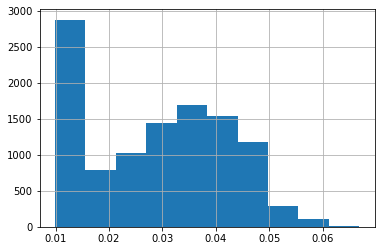

In [223]:
a._datastorer._data_df['cnn_predict'].hist()

<AxesSubplot:>

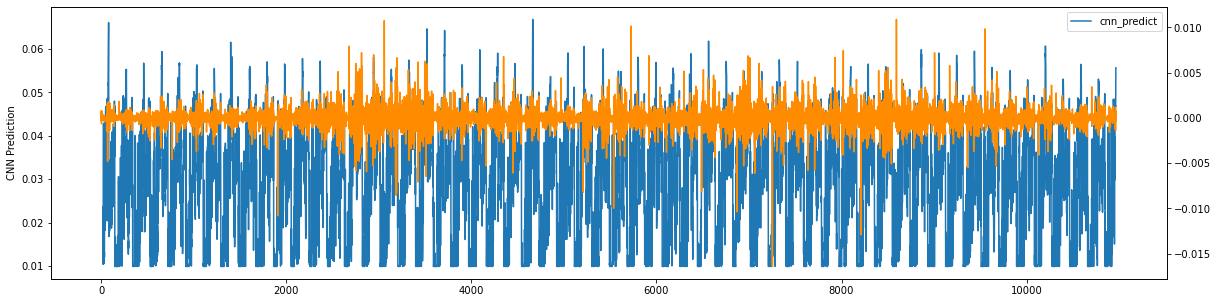

In [229]:
axes = a._datastorer._data_df[['cnn_predict']].plot()
axes.set_ylabel('CNN Prediction')
axes2 = axes.twinx()
a._datastorer._data_df['close'].pct_change().plot(ax=axes2,c='darkorange',figsize=[20,5])

In [230]:
df = a._datastorer._data_df.copy()
df.head()

,timestamp,volume,open,close,high,low,cnn_predict,buy,sell,outcome
0,1641200400,9426.0,476.38,476.56,476.92,476.38,NaN,NaN,NaN,NaN
1,1641200700,1778.0,476.48,476.44,476.49,476.44,NaN,NaN,NaN,NaN
2,1641201000,9767.0,476.62,476.83,476.87,476.58,NaN,NaN,NaN,NaN
3,1641201300,1743.0,476.84,476.53,476.84,476.53,NaN,NaN,NaN,NaN
4,1641201600,1037.0,476.65,476.82,476.82,476.62,NaN,NaN,NaN,NaN


In [231]:
df['pct_change_close'] = df['close'].pct_change(-5)

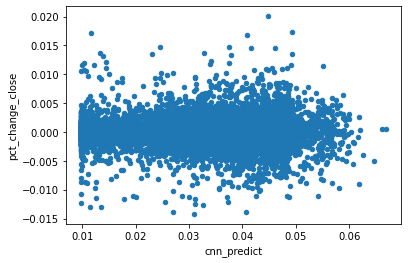

In [242]:
from matplotlib import pyplot as plt
df[['pct_change_close','cnn_predict']].dropna().sample(10**4).plot.scatter(y='pct_change_close',x='cnn_predict')
plt.show()

<AxesSubplot:xlabel='cnn_predict', ylabel='pct_change_close'>

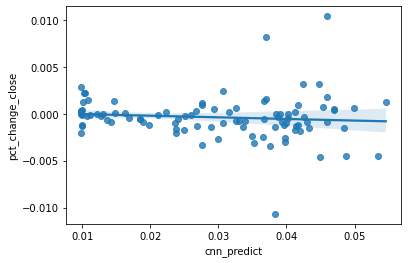

In [245]:
import seaborn as sns
sns.regplot(x="cnn_predict", y="pct_change_close", data=df[['pct_change_close','cnn_predict']].sample(10**2))

<AxesSubplot:>

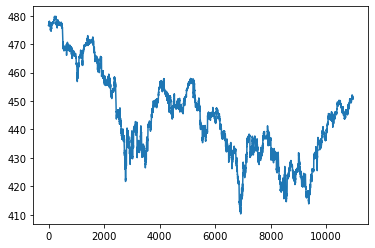

In [227]:
a._datastorer._data_df['close'].plot()

In [ ]:
import pandas as pd
import numpy as np
import pickle
import time
import math
from matplotlib import pyplot as plt
import sys

import warnings
warnings.simplefilter('ignore', np.RankWarning)

'''
dataset which accepts data points through time. Has two modes:
- irregular:
    - stores random datapoints through time.
    - doesn't perform any checks, just stores the data in it's raw form
- regular:
    - stores the data through time
    - checks its regular, checks for any missing datapoints
    - interpolates missing data points, if missing
    - calculates indicators like RSI, gradients of varying order, etc....
    - can splice in an irregular dataset into a regular one?
'''

class DataStoreException(Exception):
    pass


class DataStore:
    ''' Class which iteratively stores data points, calculating statistical indicators as it goes along.'''

    def __init__(self,
                name:str,
                cold_start: bool=True,
                is_regular: bool=True, 
                indicators: list=['rolling_mean_30','rolling_median_30','calc_trend_30','calc_acceleration_30']):

        self._name = name
        self.init_time = time.time()
        self._unique_id = f'{name}_{self.init_time}'

        self._data = pd.DataFrame()
        self.is_regular = is_regular

        # Indicators is a list contain all the indicators which will be calculated on the go as each data point is added
        self._indicators = indicators

        #self.mlp = joblib.load('/home/cemlyn/Documents/BinanceBot/app/data/models/mlp_model.bz2')
        self.mlp_covars = list()
    
    def add_datum(self,datum:pd.DataFrame):
        ''' Add new data from the websocket feed to here - Note that data points are only added when the kline is closed. '''
        # Append new data points
        self._data = pd.concat([self._data,datum],axis=0)

        if not self.check_is_regular():
            pass
        
        self.calc_indicators(*self._indicators)


    def insert_datum(self,datum:pd.DataFrame):
        self._data = self._data.combine_first(datum)


    def check_is_regular(self):
        ''' Checks the close times series to see if time intervals are regular. '''
        close_times = self._data.reset_index()[['close-time']].copy()

        if len(close_times)<2:
            return True

        close_times.loc[:,'close-time-diff'] = close_times['close-time'].diff()

        if (close_times['close-time-diff'].dropna().nunique())>1:
            return False
        else:
            return True
    

    def calc_indicators(self,*args):
        for arg in args:
            func = getattr(DataStore,arg)
            self.calc_indicator(func)


    def calc_indicator(self,func):
        ''' Calculates values for the indicator. '''
        indicator_name = func.__name__
        indicator_value = func(self._data['close-price'])

        if indicator_name not in self._data:
            self._data.loc[:,indicator_name] = indicator_value
        else:
            indicator_index_value = self._data.columns.tolist().index(indicator_name)
            self._data.iloc[-1,indicator_index_value] = indicator_value



    @staticmethod
    def rolling_mean_30(series):
        return np.mean(series.iloc[-30:])

    @staticmethod
    def rolling_median_30(series):
        return np.median(series.iloc[-30:])

    @staticmethod
    def calc_trend_30(series):
        x = series.iloc[-30:].index.astype(float).values
        y = series.iloc[-30:].astype(float).values
        
        if len(series)>3:
            grad = np.polyfit(x,y,1,full=False)[0]
        else:
            grad = np.nan
        return grad

    @staticmethod
    def calc_trend(series):
        x = series.dropna().index.astype(float).values
        y = series.dropna().astype(float).values
        if len(y)>3:
            grad = np.polyfit(x,y,1,full=False)[0]
        else:
            grad = np.nan
        return grad

    @staticmethod
    def calc_acceleration_30(series):
        first_order = series.iloc[-60:].rolling(30).apply(lambda x: DataStore.calc_trend(x))
        first_order = first_order.iloc[-30:]
        return DataStore.calc_trend(first_order)

# if __name__ == "__main__":
    
#     store = DataStore(name="Test")

#     df = pd.read_csv('bot.csv',index_col=0)

#     for n,row in enumerate(df.iterrows()):
#         store.add_datum(row[1].to_frame().T)

#     store._data.to_csv('cvb.csv')